## Analysis of scraped data form KV.ee

### Import of packages

In [1]:
import os # this is needed atleast for me because otherwise reprojection of coordinate systems does not work. 
os.environ['PROJ_DATA'] = r'C:\Users\Dan\micromamba\envs\geopython2025\Library\share\proj'
os.environ['PROJ_LIB'] = r'C:\Users\\Dan\micromamba\envs\geopython\Library\share\proj'

In [2]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
import matplotlib.pyplot as plt
from shapely.ops import nearest_points
from tqdm import tqdm
import numpy as np
import matplotlib.patches as mpatches

In [3]:
import mapclassify
import matplotlib.colors as mcolors
from mapclassify import NaturalBreaks
import contextily as ctx
from networkx import ego_graph
from shapely.geometry import box
from itertools import chain
import seaborn as sns
import matplotlib

In [4]:
# spatial libs
import libpysal
from libpysal.weights import KNN, DistanceBand
from esda.moran import Moran
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
from esda.moran import Moran_BV
from libpysal.weights import KNN
from spreg import ML_Lag, ML_Error

In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Data setup

In [7]:
tqdm.pandas()

In [8]:
# Tartu only for now
df = pd.read_csv("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_csvs/listings_cleaned_tartu.csv", sep=";") 
gdf_rent = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf_rent = gdf_rent.to_crs(epsg=3301) # reprojecting the data into the Estonian national coordinate system. So from a geographic coordinate system to a projected coordinate system


In [9]:
#gdf_rent

## OSM download

### OSM roads downlad

In [10]:
# Defining the study area
place_name = "Tartu, Estonia"
gdf_place = ox.geocode_to_gdf(place_name) # queries OpenStreetMap service to find the geographical boundary polygon of Tartu city not including the rural areas such as former Tähtvere municipality
polygon = gdf_place.geometry.iloc[0] # extracts the polygon

In [11]:
# Downloading the streetnetwork form OpenStreetMap
G = ox.graph_from_polygon(polygon, network_type='walk') # downloads the street network that is inside the polygon
G = ox.project_graph(G, to_crs='EPSG:3301')  # reprojecting the data into the Estonian national coordinate system 

### OSM services download

In [12]:
# Getting all the tags that are classified as amenities form OpenStreetmaps data that are inside the study area
tags_amenity = {"amenity": True}
amenity = ox.features_from_polygon(polygon, tags_amenity)
amenity = amenity.to_crs(gdf_rent.crs)

In [13]:
# Since some of these POI geometries are points and some are polygons we will split them for cleaning
amenity_points = amenity[amenity.geometry.type == "Point"]
amenity_polygons = amenity[amenity.geometry.type.isin(["Polygon", "MultiPolygon"])]

In [14]:
# Turning polygon geometries into centroids
amenity_polygons_centroids = amenity_polygons.copy()
amenity_polygons_centroids["geometry"] = amenity_polygons_centroids.geometry.centroid

In [15]:
# Combining the data that were points and the data that were polygons but were turned into points
amenity_combined = pd.concat([amenity_points, amenity_polygons_centroids])
amenity_combined = amenity_combined.reset_index(drop=True)

In [16]:
# Getting all the tags that are classified as shops and leisure form OpenStreetmaps data that are inside the study area
tags_shop = {"shop": True}
tags_leisure = {"leisure": True}
shops = ox.features_from_polygon(polygon, tags_shop)
leisure = ox.features_from_polygon(polygon, tags_leisure)
# Matching the CRS (coordinate referece system)
shops = shops.to_crs(gdf_rent.crs)
leisure = leisure.to_crs(gdf_rent.crs)

In [17]:
# Shops
shops_points = shops[shops.geometry.type == "Point"]
shops_polygons = shops[shops.geometry.type.isin(["Polygon", "MultiPolygon"])]

# Leisure
leisure_points = leisure[leisure.geometry.type == "Point"]
leisure_polygons = leisure[leisure.geometry.type.isin(["Polygon", "MultiPolygon"])]

In [18]:
# Shops
shops_polygons_centroids = shops_polygons.copy()
shops_polygons_centroids["geometry"] = shops_polygons_centroids.geometry.centroid

# Leisure
leisure_polygons_centroids = leisure_polygons.copy()
leisure_polygons_centroids["geometry"] = leisure_polygons_centroids.geometry.centroid

In [19]:
# Shops
shops_combined = pd.concat([shops_points, shops_polygons_centroids]).reset_index(drop=True)

# Leisure
leisure_combined = pd.concat([leisure_points, leisure_polygons_centroids]).reset_index(drop=True)

#### Looking at the data

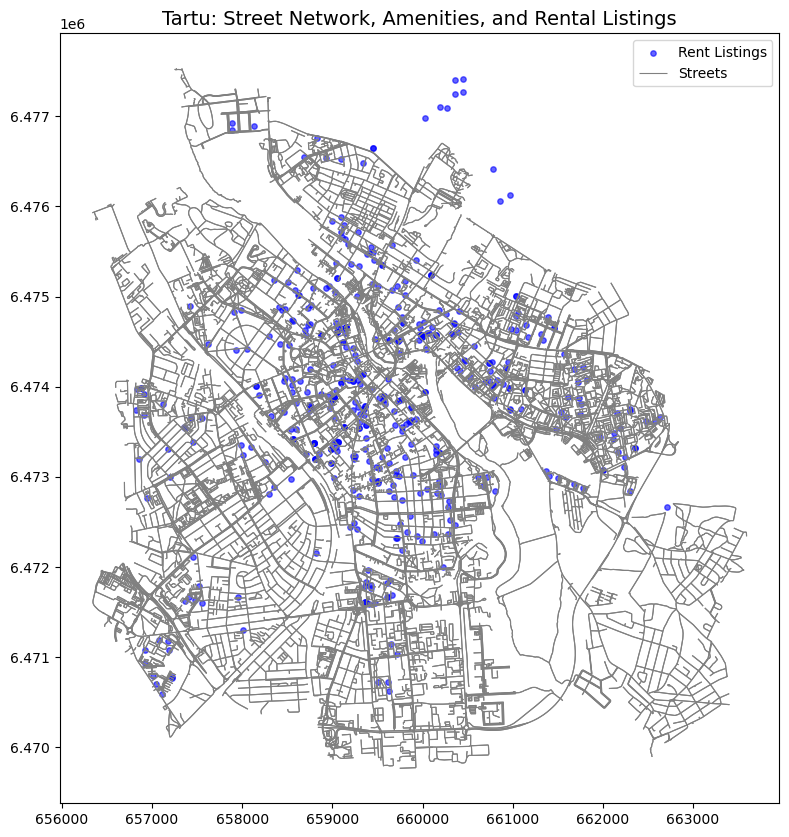

In [20]:
# Get nodes and edges from the graph as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

# Create a base plot
fig, ax = plt.subplots(figsize=(10, 10))

# Optional: plot rental listings too
gdf_rent.plot(ax=ax, markersize=15, color='blue', alpha=0.6, label="Rent Listings")

# Plot the edges (streets)
edges.plot(ax=ax, linewidth=0.8, color='gray', label="Streets")

# Plot the nodes (intersections)
#nodes.plot(ax=ax, markersize=5, color='black', label="Nodes")

# Plot amenities (POIs)
#amenity_combined.plot(ax=ax, markersize=20, color='red', alpha=0.6, label="Amenities")



# Add legend and title
ax.set_title("Tartu: Street Network, Amenities, and Rental Listings", fontsize=14)
ax.legend()

plt.show()

In [21]:
pd.set_option("display.max_rows", None)
print(amenity_combined["amenity"].value_counts())

amenity
bench                     940
parking                   762
bicycle_parking           336
waste_basket              284
recycling                 102
parking_space              97
bicycle_rental             76
restaurant                 64
atm                        60
cafe                       53
parcel_locker              49
kindergarten               45
university                 44
pharmacy                   43
fast_food                  37
post_box                   37
fuel                       35
school                     34
shelter                    31
toilets                    27
parking_entrance           24
vending_machine            20
car_wash                   19
place_of_worship           18
bar                        17
charging_station           16
waste_disposal             14
pub                        13
drinking_water             11
doctors                    10
clinic                      9
bank                        8
loading_dock                7
ve

In [22]:
for col in amenity_combined.columns:
    print(col)

geometry
addr:city
addr:country
addr:housenumber
addr:postcode
addr:street
amenity
brand
dispensing
email
healthcare
name
opening_hours
operator
phone
ref
collection_times
operator:wikidata
operator:wikipedia
check_date
contact:email
contact:phone
contact:website
outdoor_seating
payment:debit_cards
payment:mastercard
payment:visa
wheelchair
opening_hours:kitchen
website
cuisine
url
changing_table
check_date:opening_hours
indoor_seating
internet_access
toilets
addr:floor
brewery
level
payment:cash
toilets:wheelchair
diet:vegetarian
payment:credit_cards
lunch
name:ru
historic
check_date:smoking
smoking
internet_access:fee
internet_access:ssid
wikidata
recycling:beverage_cartons
recycling:cans
recycling:cardboard
recycling:cartons
recycling:glass_bottles
recycling:magazines
recycling:newspaper
recycling:paper
recycling:paper_packaging
recycling:plastic
recycling:plastic_bottles
recycling:plastic_packaging
recycling_type
brand:wikidata
cash_in
indoor
alt_name
currency:EUR
drive_through
sou

In [23]:
amenity_combined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3496 entries, 0 to 3495
Columns: 315 entries, geometry to type
dtypes: geometry(1), object(314)
memory usage: 8.4+ MB


In [24]:
# checking types
pd.set_option("display.max_rows", None)
print(shops_combined["shop"].value_counts())  # Top shop types
print(leisure_combined["leisure"].value_counts())  # Top leisure types



shop
clothes                63
supermarket            52
hairdresser            21
car                    21
florist                20
beauty                 19
electronics            17
furniture              17
sports                 16
convenience            14
doityourself           13
mall                   13
shoes                  13
car_repair             12
bicycle                11
pet                    10
bakery                 10
optician                9
tobacco                 8
books                   8
yes                     8
second_hand             8
kiosk                   7
jewelry                 7
toys                    6
fishing                 6
car_parts               6
hardware                6
stationery              6
tyres                   5
alcohol                 5
computer                5
medical_supply          5
communication           5
craft                   4
butcher                 4
bed                     4
gift                    4
tailor 

In [25]:
pd.reset_option("display.max_rows")

In [26]:
# Checking column names
print(list(shops_combined.columns))


['geometry', 'addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street', 'brand', 'check_date:opening_hours', 'name', 'old_name', 'opening_hours', 'operator', 'phone', 'shop', 'website', 'wheelchair', 'addr:country', 'addr:floor', 'check_date', 'level', 'not:brand:wikidata', 'payment:cash', 'payment:credit_cards', 'payment:debit_cards', 'drive_through', 'payment:mastercard', 'payment:visa', 'atm', 'brand:wikidata', 'brand:wikipedia', 'email', 'contact:email', 'contact:phone', 'contact:website', 'addr:housename', 'designation', 'source', 'clothes', 'internet_access', 'craft', 'organic', 'alt_name', 'name:en', 'contact:facebook', 'fax', 'amenity', 'outdoor_seating', 'takeaway', 'alcohol', 'service:bicycle:rental', 'service:bicycle:repair', 'service:bicycle:retail', 'service:bicycle:second_hand', 'description', 'repair', 'sale', 'opening_hours:signed', 'second_hand', 'payment:coins', 'branch', 'name:et', 'contact:skype', 'beauty', 'payment:contactless', 'note', 'religion', 'indoor', 

In [27]:
print(list(leisure_combined.columns))

['geometry', 'access', 'covered', 'indoor', 'leisure', 'net', 'panoramax', 'reservation', 'sport', 'surface', 'level', 'opening_hours', 'website', 'contact:website', 'name', 'fee', 'phone', 'name:et', 'bench', 'lit', 'material', 'roof', 'addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street', 'contact:email', 'contact:facebook', 'contact:instagram', 'contact:phone', 'check_date', 'operator', 'payment:cash', 'start_date', 'fitness_station', 'wheelchair', 'addr:country', 'addr:floor', 'payment:credit_cards', 'payment:debit_cards', 'baby', 'description', 'name:en', 'name:fi', 'name:vro', 'amenity', 'internet_access', 'repair', 'payment:online_payment', 'email', 'bar', 'blind', 'athletics', 'name:de', 'url', 'wikidata', 'wikipedia', 'source', 'garden:type', 'landcover', 'capacity', 'building', 'height', 'maaamet:ETAK', 'old_addr:housenumber', 'old_addr:street', 'source:addr', 'addr:full', 'building:levels', 'roof:shape', 'alt_name', 'old_name', 'barrier', 'note', 'check_date:openin

## Osm data cleaning

#### Cleaning amenities data

In [28]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio = amenity_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep = non_missing_ratio[non_missing_ratio >= 0.2].index
amenity_reduced = amenity_combined[cols_keep]
print(list(amenity_reduced.columns))

['geometry', 'amenity', 'backrest']


In [29]:
amenity_cleaned = amenity_reduced.drop(columns=["backrest"]) # removing backrest aswell because that is not useful at all

In [30]:
amenity_cleaned[["geometry", "amenity"]].isna().sum() # check for missing values.

geometry    0
amenity     0
dtype: int64

In [31]:
# amenities that are likely to influence rent prices
important_amenities = [
    # education
    "school", "university", "college", "kindergarten", "childcare", "training", "language_school",
    # health
    "pharmacy", "hospital", "clinic", "doctors", "dentist", 
    # admin
    "atm", "bank", "post_office", "courthouse", "townhall",
    # transport
    "parking", "parking_space", "bicycle_parking",
    "charging_station", "fuel", "taxi", "bus_station",
    # leisure
    "restaurant", "cafe", "bar", "pub", "fast_food", "cinema", "theatre",
    "arts_centre", "concert_hall", "nightclub",
    # public
    "community_centre", "social_facility", "library", "marketplace", "public_building",
    "coworking_space", "events_venue",
    # safety
    "police", "fire_station",
    # utilities
    "post_box", "parcel_locker", "recycling", "waste_disposal", "drinking_water"
]

In [32]:
amenity_clean = amenity_cleaned[amenity_cleaned["amenity"].isin(important_amenities)].reset_index(drop=True)


In [33]:
pd.set_option("display.max_rows", None)
print(amenity_clean["amenity"].value_counts())

amenity
parking             762
bicycle_parking     336
recycling           102
parking_space        97
restaurant           64
atm                  60
cafe                 53
parcel_locker        49
kindergarten         45
university           44
pharmacy             43
fast_food            37
post_box             37
fuel                 35
school               34
bar                  17
charging_station     16
waste_disposal       14
pub                  13
drinking_water       11
doctors              10
clinic                9
bank                  8
community_centre      6
college               6
courthouse            6
theatre               5
social_facility       5
library               5
dentist               4
nightclub             4
post_office           4
taxi                  4
fire_station          3
coworking_space       3
arts_centre           3
hospital              3
training              3
marketplace           3
cinema                2
events_venue          2
concert_

In [34]:
pd.reset_option("display.max_rows")

#### Cleaning shops data

In [35]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio_shops = shops_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep_shops = non_missing_ratio_shops[non_missing_ratio_shops >= 0.2].index
shops_reduced = shops_combined[cols_keep_shops].copy()
print(list(shops_reduced.columns))

['geometry', 'addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street', 'name', 'opening_hours', 'operator', 'phone', 'shop', 'website', 'wheelchair', 'addr:country', 'check_date', 'level']


In [36]:
shops_reduced[['geometry', 'addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street', 'name', 'opening_hours', 'operator', 'phone', 'shop', 'website', 'wheelchair', 'addr:country', 'check_date', 'level']].isna().sum() # check for missing values.
# looking to see if these fields could be valuable

geometry              0
addr:city           352
addr:housenumber    252
addr:postcode       389
addr:street         253
name                 46
opening_hours       167
operator            441
phone               350
shop                  0
website             333
wheelchair          390
addr:country        422
check_date          442
level               376
dtype: int64

In [37]:
shops_clean = shops_reduced.drop(columns=['addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street', 'name', 'opening_hours', 'operator', 'phone', 'website', 'wheelchair', 'addr:country', 'check_date', 'level']) 
# removing other data. doesn't seem useful

In [38]:
shops_clean

,geometry,shop
0,POINT (659668.71 6474583.027),supermarket
1,POINT (659124.663 6472588.706),supermarket
2,POINT (658645.935 6473847.444),alcohol
3,POINT (660051.044 6473735.196),supermarket
4,POINT (658710.274 6473699.497),erotic
...,...,...
567,POINT (658348.729 6476689.433),supermarket
568,POINT (660591.09 6471219.614),trade
569,POINT (657368.941 6473042.632),supermarket
570,POINT (660163.076 6473455.646),supermarket


In [39]:
weird_shops = ["yes", "no", "vacant"]  # basically NaN values
shops_clean = shops_clean[~shops_clean["shop"].isin(weird_shops)]

In [40]:
shop_counts = shops_clean["shop"].value_counts()

# Keeping shop types that appear at least 3 times
shops_clean = shops_clean[shops_clean["shop"].isin(shop_counts[shop_counts >= 3].index)]

In [41]:
pd.set_option("display.max_rows", None)
print(shops_clean["shop"].value_counts()) 

shop
clothes           63
supermarket       52
car               21
hairdresser       21
florist           20
beauty            19
furniture         17
electronics       17
sports            16
convenience       14
shoes             13
mall              13
doityourself      13
car_repair        12
bicycle           11
pet               10
bakery            10
optician           9
books              8
tobacco            8
second_hand        8
kiosk              7
jewelry            7
toys               6
hardware           6
fishing            6
car_parts          6
stationery         6
medical_supply     5
computer           5
communication      5
tyres              5
alcohol            5
bed                4
craft              4
butcher            4
gift               4
locksmith          3
dry_cleaning       3
baby_goods         3
erotic             3
appliance          3
general            3
copyshop           3
e-cigarette        3
greengrocer        3
trade              3
bag     

In [42]:
pd.reset_option("display.max_rows")

#### Cleaning leisure data

In [43]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio_leisure = leisure_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep_leisure = non_missing_ratio_leisure[non_missing_ratio_leisure >= 0.2].index
leisure_reduced = leisure_combined[cols_keep_leisure].copy()
print(list(leisure_reduced.columns))

['geometry', 'access', 'leisure', 'sport', 'garden:type']


In [44]:
leisure_reduced[['geometry', 'access', 'leisure', 'sport', 'garden:type']].isna().sum() # check for missing values.
# looking to see if these fields could be valuable

geometry         0
access         574
leisure          0
sport          684
garden:type    533
dtype: int64

In [45]:
leisure_clean = leisure_reduced.drop(columns=[ 'access', 'sport', 'garden:type']) # removing other data. doesn't seem useful

In [46]:
pd.set_option("display.max_rows", None)
print(leisure_clean["leisure"].value_counts()) 

leisure
garden              392
pitch               189
playground          137
park                 69
fitness_station      27
sports_centre        17
track                13
picnic_table          7
fitness_centre        7
dog_park              6
bleachers             6
indoor_play           5
marina                5
stadium               4
hackerspace           3
swimming_area         3
nature_reserve        3
firepit               2
disc_golf_course      2
outdoor_seating       2
village_swing         2
bowling_alley         2
sauna                 2
trampoline_park       2
slipway               2
ice_rink              1
tanning_salon         1
swimming_pool         1
sports_hall           1
horse_riding          1
Name: count, dtype: int64


In [47]:
pd.reset_option("display.max_rows")

In [48]:
# this data requires no further cleaning 

## Osm data aggregation

#### Aggregating amenities data

In [49]:
# making a dictionary for amenity groups
amenity_categories = {
    "early_childhood": ["kindergarten", "childcare"],
    "primary_secondary": ["school"], 
    "higher_education": ["university", "college"],
    "supplementary_education": ["training", "language_school"],
    
    "healthcare": ["pharmacy", "clinic", "hospital", "doctors", "dentist"],
    
    "finance_admin": ["atm", "bank", "courthouse", "post_office", "townhall"],
    
    "transport": ["bus_station", "taxi", "fuel", "charging_station", "police", "fire_station", "bicycle_rental"],
    
    "parking": ["parking", "parking_space", "bicycle_parking"],
    
    "food_drink": ["restaurant", "cafe", "fast_food", "bar", "pub", "marketplace"],

    "community_social": ["community_centre", "social_facility", "library", "coworking_space","public_building", "events_venue", "arts_centre", "theatre", "concert_hall", "nightclub", "cinema"],
    
    "services_utilities": ["recycling", "waste_disposal", "drinking_water", "post_box", "parcel_locker"]}

In [50]:
amenity_to_category = {
    amenity: category
    for category, amenities in amenity_categories.items()
    for amenity in amenities
}

In [51]:
# Function to map an amenity to its group
amenity_clean["category"] = amenity_clean["amenity"].map(amenity_to_category)


In [52]:
amenity_clean

,geometry,amenity,category
0,POINT (656886.089 6472310.714),pharmacy,healthcare
1,POINT (658428.005 6476286.708),post_box,services_utilities
2,POINT (659253.18 6474336.676),bar,food_drink
3,POINT (659262.47 6474339.294),restaurant,food_drink
4,POINT (659280.972 6474343.334),restaurant,food_drink
...,...,...,...
1969,POINT (659228.109 6474730.754),parking,parking
1970,POINT (659230.173 6474714.131),parking,parking
1971,POINT (658890.687 6470964.48),parking,parking
1972,POINT (657150.224 6475692.097),parking,parking


In [53]:
print(amenity_clean["category"].value_counts(dropna=False))

category
parking                    1195
services_utilities          213
food_drink                  187
finance_admin                79
healthcare                   69
transport                    60
higher_education             50
early_childhood              46
community_social             37
primary_secondary            34
supplementary_education       4
Name: count, dtype: int64


#### Aggregating shops data

In [54]:
shop_categories = {
    "clothing": ["clothes", "shoes", "jewelry", "bag", "tailor", "second_hand"],
    "food_grocery": ["supermarket", "bakery", "butcher", "greengrocer", "convenience", "alcohol"],
    "health_beauty": ["hairdresser", "beauty", "optician", "medical_supply", "e-cigarette"],
    "home_furniture": ["furniture", "appliance", "doityourself", "hardware", "bed"],
    "electronics": ["electronics", "computer", "communication"],
    "sports_leisure": ["sports", "toys", "fishing"],
    "vehicles": ["car", "car_repair", "car_parts", "bicycle", "tyres"],
    "misc_services": ["kiosk", "locksmith", "dry_cleaning", "copyshop", "gift", "trade", "stationery", "craft", "baby_goods", "erotic", "general", "mall", "florist"],
    "other": ["books", "tobacco", "pet"]
}

In [55]:
shop_to_category = {
    shop: category
    for category, shops in shop_categories.items()
    for shop in shops
}

In [56]:
shops_clean["category"] = shops_clean["shop"].map(shop_to_category)

In [57]:
print(shops_clean["category"].value_counts(dropna=False))


category
clothing          97
food_grocery      88
misc_services     75
health_beauty     57
vehicles          55
home_furniture    43
sports_leisure    28
electronics       27
other             26
Name: count, dtype: int64


#### Aggregating leisure data

In [58]:
leisure_categories = {
    "parks_green": ["garden", "park", "nature_reserve", "dog_park"],
    "sports_facilities": ["pitch", "sports_centre", "fitness_station", "fitness_centre", "track", "stadium", "sports_hall", "bowling_alley", "trampoline_park", "horse_riding", "ice_rink", "swimming_pool","disc_golf_course","swimming_area"],
    "play_recreation": ["playground", "indoor_play", "picnic_table", "bleachers", "outdoor_seating", "village_swing", "firepit", "sauna", "marina", "slipway"],
    "other": ["hackerspace", "tanning_salon"]
}

In [59]:
leisure_to_category = {
    leisure: category
    for category, leisures in leisure_categories.items()
    for leisure in leisures
}

In [60]:
leisure_clean["category"] = leisure_clean["leisure"].map(leisure_to_category)

In [61]:
print(leisure_clean["category"].value_counts(dropna=False))

category
parks_green          470
sports_facilities    270
play_recreation      170
other                  4
Name: count, dtype: int64


#### Saving the datasets

In [62]:
amenity_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/amenity_clean_trt.gpkg", layer="amenity", driver="GPKG")
shops_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/shop_clean_trt.gpkg", layer="shop", driver="GPKG")
leisure_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/leisure_clean_trt.gpkg", layer="leisure", driver="GPKG")

# Analysis

In [63]:
# import here so do not have to run the whole code again and results dont change since osm data might change in time

In [64]:
gdf_amenity = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/amenity_clean_trt.gpkg", layer="amenity")
gdf_shop = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/shop_clean_trt.gpkg", layer="shop")
gdf_leisure = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/leisure_clean_trt.gpkg", layer="leisure")

In [65]:
#print(gdf_amenity.columns)
#print(gdf_shop.columns)
#print(gdf_leisure.columns)

In [66]:
#gdf_amenity["category"].unique()

In [67]:
#gdf_rent.columns

In [68]:
gdf_rent['price_per_m2'] = gdf_rent['price'] / gdf_rent['area_sqm'] # making price per m2 for rent data.

### Finding distances

In [69]:
# finding the closest node to each service and rental

In [70]:
# nearest node to each rental
gdf_rent["nearest_node"] = ox.distance.nearest_nodes(G, gdf_rent.geometry.x, gdf_rent.geometry.y)

# nearest node to each service type
for gdf in [gdf_amenity, gdf_shop, gdf_leisure]:
    gdf["nearest_node"] = ox.distance.nearest_nodes(G, gdf.geometry.x, gdf.geometry.y)

### Finding distance to city center

In [71]:
city_center = Point(659247,6474311) # point on raekoja plats considered for city center.

In [72]:
center_node = ox.distance.nearest_nodes(G, X=city_center.x, Y=city_center.y)
center_node

7879027080

In [73]:
dist_from_center = nx.single_source_dijkstra_path_length(G,center_node,weight='length')

In [74]:
gdf_rent["dist_center"] = gdf_rent["nearest_node"].map(dist_from_center)

### Finding distances between rentals and closest amenity category

In [75]:
all_categories = (
    list(gdf_amenity["category"].unique()) +
    list(gdf_shop["category"].unique()) +
    list(gdf_leisure["category"].unique()))
print(all_categories)

['healthcare', 'services_utilities', 'food_drink', 'community_social', 'finance_admin', 'supplementary_education', 'higher_education', 'parking', 'early_childhood', 'transport', 'primary_secondary', 'food_grocery', 'misc_services', 'vehicles', 'home_furniture', 'health_beauty', 'other', 'clothing', 'electronics', 'sports_leisure', 'sports_facilities', 'play_recreation', 'other', 'parks_green']


In [76]:
category_nodes = {}

# for filling in the dict
def add_category_nodes(gdf):
    for cat, group in gdf.groupby("category"):
        category_nodes[cat] = set(group["nearest_node"])

add_category_nodes(gdf_amenity)
add_category_nodes(gdf_shop)
add_category_nodes(gdf_leisure)

In [77]:
category_distances = {}
for cat, nodeset in category_nodes.items():
    print(f"calculate network distances for category: {cat} ({len(nodeset)} sources)")
    category_distances[cat] = nx.multi_source_dijkstra_path_length(G, nodeset, weight='length')

calculate network distances for category: community_social (36 sources)
calculate network distances for category: early_childhood (46 sources)
calculate network distances for category: finance_admin (67 sources)
calculate network distances for category: food_drink (151 sources)
calculate network distances for category: healthcare (63 sources)
calculate network distances for category: higher_education (46 sources)
calculate network distances for category: parking (1001 sources)
calculate network distances for category: primary_secondary (33 sources)
calculate network distances for category: services_utilities (162 sources)
calculate network distances for category: supplementary_education (4 sources)
calculate network distances for category: transport (56 sources)
calculate network distances for category: clothing (57 sources)
calculate network distances for category: electronics (21 sources)
calculate network distances for category: food_grocery (80 sources)
calculate network distances 

In [78]:
for cat, dist_dict in category_distances.items():
    gdf_rent[f"dist_{cat}"] = gdf_rent["nearest_node"].map(dist_dict)

In [79]:
#print(gdf_shop.columns)

### Finding correlations between distance to services and price (deprecated/not relevant)

In [80]:
corr = gdf_rent.filter(like='dist_').assign(price=gdf_rent['price']).corr()
print(corr['price'].sort_values())

dist_center                    -0.101984
dist_higher_education          -0.088440
dist_supplementary_education   -0.060961
dist_parks_green               -0.054341
dist_play_recreation           -0.043471
dist_other                     -0.032364
dist_sports_leisure            -0.024394
dist_services_utilities        -0.021320
dist_parking                   -0.007487
dist_transport                  0.020421
dist_misc_services              0.025550
dist_healthcare                 0.029197
dist_sports_facilities          0.030050
dist_finance_admin              0.033109
dist_community_social           0.037822
dist_food_grocery               0.057432
dist_primary_secondary          0.074616
dist_vehicles                   0.080063
dist_clothing                   0.089540
dist_health_beauty              0.090840
dist_food_drink                 0.105807
dist_electronics                0.117287
dist_home_furniture             0.135772
dist_early_childhood            0.188174
price           

In [81]:
# intresting correlations. rent prices near education services like schools seem to be lower and near higher education they seem to be higher.
# THIS IS WRONG BECAUSE RENTS ARE AUTOCORRELATED WITH EACHOTHER
# Toblers first law of geography : "everything is related to everything else, but near things are more related than distant things."

### Controlling for spacial autocorrelation (price)

In [82]:
# create spatial weights matrix. Meaning it will find 8 of the nearest rentals based on coordinates.
w = KNN.from_dataframe(gdf_rent, k=10) # assings weight 1 to the closest 8 and 0 to everyone else
w.transform = 'r'  # standardizes the weights. If is neighbour gets devided by "k". So 1/8 will be the weight of each neighbour

In [83]:
# Calculate bivariate Moran's I for each distance variable
# what is  bivariate Moran's I
# a test that looks for spatial correlation between two variables while accounting for spatial autocorrelation
# IMPORTANT to find if higher/lower rents are nearer to some service categories
results = {}
for col in gdf_rent.filter(like='dist_').columns:
    moran_bv = Moran_BV(gdf_rent[col], gdf_rent['price'], w) # finding bivariate Moran's I between distances, rent and spacial weights
    results[col] = {
        'I': moran_bv.I,
        'p_value': moran_bv.p_sim,  # using permutation test to see if values are satistically signifficant
        'z_score': moran_bv.z_sim}

In [84]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('I')
print(results_df)

                                     I  p_value   z_score
dist_center                  -0.117063    0.004 -2.431583
dist_parks_green             -0.091424    0.006 -2.297528
dist_higher_education        -0.088768    0.041 -1.771439
dist_supplementary_education -0.087562    0.040 -1.750182
dist_other                   -0.045278    0.188 -0.890178
dist_sports_leisure          -0.026761    0.274 -0.598193
dist_play_recreation         -0.003797    0.460 -0.134444
dist_finance_admin            0.003536    0.442  0.090845
dist_services_utilities       0.003544    0.447  0.126540
dist_community_social         0.007266    0.422  0.149588
dist_misc_services            0.012946    0.376  0.331414
dist_parking                  0.016914    0.314  0.495365
dist_sports_facilities        0.018278    0.349  0.393665
dist_transport                0.030577    0.218  0.805403
dist_healthcare               0.039005    0.129  1.155332
dist_health_beauty            0.044339    0.148  1.023133
dist_clothing 

In [85]:
# significant relationships p < 0.05
# Still some relationships persist. Proximity to higher education and parks is associated with higher prices. Bigger distance to education and home furniture is associated with lower prices. 

In [86]:
# spatial lag modeling to see if after controlling for spacial autocorrelation there still is a relationship.

In [87]:
# selecting variables that showed a significant relationship
significant_vars = [
    'dist_parks_green',
    'dist_higher_education', 
    'dist_supplementary_education',
    'dist_early_childhood',
    'dist_home_furniture']

In [88]:
# preparing the data
# because ML_Lag wants the data in numpy arrays
X = gdf_rent[significant_vars].values # selects only distances that were significant in previous tests
y = gdf_rent['price'].values # gets prices

In [89]:
# adding constant
X = np.column_stack([np.ones(len(X)), X]) # adding an intercept
var_names = ['constant'] + significant_vars # adding names to variables

In [90]:
# spatial lag model to see if prices influence nearby prices
lag_model = ML_Lag(
    y, X, w=w,
    name_y='price',
    name_x=var_names,
    name_w='spatial_weights')

In [91]:
print(lag_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :       price                Number of Observations:         448
Mean dependent var  :    487.1652                Number of Variables   :           7
S.D. dependent var  :    215.7763                Degrees of Freedom    :         441
Pseudo R-squared    :      0.0679
Spatial Pseudo R-squared:  0.0534
Log likelihood      :  -3028.1207
Sigma-square ML     :  43316.0819                Akaike info criterion :    6070.241
S.E of regression   :    208.1252                Schwarz criterion     :    6098.975

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------

In [92]:
# When controlling for spacial autocorrelation some of the signifficant results go away such as parks and home_furniture stores.
# Smaller distance to higher education still seems to increase prices and bigger distance form regular education seems to lower prices. Look at coefficient values.
# every 1000m form a higher education service your rent will decrease by 33€ 
# every 1000m you are from a regular education service your rent will be increase by 85€. 
# so it is good to be far from univercity buildings and close to regular schools.
# There also is a spacial correlation between prices themselves. If nearby apartments cost more, others will too.

In [93]:
# These results seem werid. Especially the distance from regular schools increasing your price. It should be the other way.
# I will try to see if it can be controlled with city center being more expensive. Maybe most schools are far from the city center etc.

In [94]:
X_plus_center = gdf_rent[[
    'dist_parks_green',
    'dist_higher_education', 
    'dist_supplementary_education',
    'dist_early_childhood',
    'dist_center',
    'dist_home_furniture']].values
X_plus_center = np.column_stack([np.ones(len(X_plus_center)), X_plus_center])


In [95]:
lag_with_center = ML_Lag(
    y, X_plus_center, w=w,
    name_y='price',
    name_x=['constant', 
            'dist_parks_green',
            'dist_higher_education', 
            'dist_supplementary_education',
            'dist_early_childhood',
            'dist_center',
            'dist_home_furniture'],
    name_w='spatial_weights') # fiting a spacial lag model

In [96]:
print("MODEL WITH CITY CENTER DISTANCE")
print(lag_with_center.summary)

MODEL WITH CITY CENTER DISTANCE
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :       price                Number of Observations:         448
Mean dependent var  :    487.1652                Number of Variables   :           8
S.D. dependent var  :    215.7763                Degrees of Freedom    :         440
Pseudo R-squared    :      0.0750
Spatial Pseudo R-squared:  0.0659
Log likelihood      :  -3026.0415
Sigma-square ML     :  42977.5033                Akaike info criterion :    6068.083
S.E of regression   :    207.3102                Schwarz criterion     :    6100.921

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
----------------------------

In [97]:
# The regular education weirdness still persists. For this there might be multiple explanations. Rentals being older or in worse condition near regular education or people with kids don't rent they buy etc.
# It seems there is some colinearity between distance to center and distance to higher education since distance to higher education is not significant anymore.

### Controlling for spacial autocorrelation (price_per_m2)

In [98]:
# removing outliers
q99 = gdf_rent['price_per_m2'].quantile(0.99)
q01 = gdf_rent['price_per_m2'].quantile(0.01)
gdf_rent_clean = gdf_rent[
    (gdf_rent['price_per_m2'] >= q01) & 
    (gdf_rent['price_per_m2'] <= q99)
].copy()

In [99]:
# Rebuild spatial weights for clean dataset
w_clean = KNN.from_dataframe(gdf_rent_clean, k=10)
w_clean.transform = 'r'

In [100]:
# Calculate bivariate Moran's I for each distance variable against price_per_m2
results_m2 = {}
for col in gdf_rent_clean.filter(like='dist_').columns:
    moran_bv = Moran_BV(gdf_rent_clean[col], gdf_rent_clean['price_per_m2'], w_clean)
    results_m2[col] = {
        'I': moran_bv.I,
        'p_value': moran_bv.p_sim,
        'z_score': moran_bv.z_sim}

In [101]:
results_m2_df = pd.DataFrame(results_m2).T
results_m2_df = results_m2_df.sort_values('I')
print("BIVARIATE MORAN'S I: Distance variables vs Price per m²")
print(results_m2_df)

BIVARIATE MORAN'S I: Distance variables vs Price per m²
                                     I  p_value   z_score
dist_other                   -0.205196    0.001 -4.203713
dist_higher_education        -0.185159    0.001 -3.821165
dist_center                  -0.184780    0.001 -3.646745
dist_supplementary_education -0.169576    0.001 -3.482290
dist_parks_green             -0.163125    0.001 -3.874284
dist_misc_services           -0.139529    0.003 -3.231386
dist_sports_leisure          -0.131321    0.005 -2.979388
dist_electronics             -0.119290    0.002 -2.710211
dist_community_social        -0.083701    0.025 -1.850560
dist_food_drink              -0.077328    0.038 -1.705716
dist_healthcare              -0.069924    0.019 -2.003572
dist_parking                 -0.065480    0.027 -1.876724
dist_clothing                -0.058924    0.117 -1.177567
dist_primary_secondary       -0.058915    0.091 -1.330288
dist_health_beauty           -0.049161    0.141 -1.082372
dist_sports_faci

In [102]:
#patterns seem very different with price per m2

In [103]:
# Variables significant at p < 0.05 from bivariate Moran's I
significant_vars_m2 = [
    'dist_other',                    
    'dist_higher_education',         
    'dist_center',                   
    'dist_supplementary_education',  
    'dist_parks_green',              
    'dist_sports_leisure',           
    'dist_misc_services',            
    'dist_electronics',              
    'dist_food_drink',               
    'dist_parking',                  
    'dist_healthcare',               
    'dist_community_social'          
]

In [104]:
# First: fit model WITHOUT dist_center to see raw effects
vars_no_center = [v for v in significant_vars_m2 if v != 'dist_center']

X_no_center = gdf_rent_clean[vars_no_center].values
y_m2 = gdf_rent_clean['price_per_m2'].values
X_no_center = np.column_stack([np.ones(len(X_no_center)), X_no_center])
var_names_no_center = ['constant'] + vars_no_center

lag_no_center = ML_Lag(
    y_m2, X_no_center, w=w_clean,
    name_y='price_per_m2',
    name_x=var_names_no_center,
    name_w='spatial_weights'
)

print("SPATIAL LAG MODEL - WITHOUT DIST_CENTER")
print(lag_no_center.summary)

SPATIAL LAG MODEL - WITHOUT DIST_CENTER
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :price_per_m2                Number of Observations:         438
Mean dependent var  :     11.8990                Number of Variables   :          13
S.D. dependent var  :      4.0486                Degrees of Freedom    :         425
Pseudo R-squared    :      0.1084
Spatial Pseudo R-squared:  0.0724
Log likelihood      :  -1210.4902
Sigma-square ML     :     14.5944                Akaike info criterion :    2446.980
S.E of regression   :      3.8203                Schwarz criterion     :    2500.049

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------

In [105]:
# With many correlated variables in the model, nothing is individually significant except the spatial lag. Multicolinearity?

In [106]:
# Model WITH dist_center included
X_with_center = gdf_rent_clean[significant_vars_m2].values
y_m2 = gdf_rent_clean['price_per_m2'].values
X_with_center = np.column_stack([np.ones(len(X_with_center)), X_with_center])
var_names_with_center = ['constant'] + significant_vars_m2

lag_with_center = ML_Lag(
    y_m2, X_with_center, w=w_clean,
    name_y='price_per_m2',
    name_x=var_names_with_center,
    name_w='spatial_weights'
)

print("SPATIAL LAG MODEL - WITH DIST_CENTER")
print(lag_with_center.summary)

SPATIAL LAG MODEL - WITH DIST_CENTER
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :spatial_weights
Dependent Variable  :price_per_m2                Number of Observations:         438
Mean dependent var  :     11.8990                Number of Variables   :          14
S.D. dependent var  :      4.0486                Degrees of Freedom    :         424
Pseudo R-squared    :      0.1109
Spatial Pseudo R-squared:  0.0789
Log likelihood      :  -1209.6771
Sigma-square ML     :     14.5514                Akaike info criterion :    2447.354
S.E of regression   :      3.8146                Schwarz criterion     :    2504.505

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------

In [107]:
#Nothing is significant except community_social and W_price_per_m2. Farther from community/social services means higher prices. Strong spatial dependence price rises with prices of neighbors.
#  It seems that rent prices are not affected by amenities basically at all.

In [108]:
# Rental prices strongly cluster: a high-price apartment is surrounded by other high-price apartments. 

### Walkability analysis

In [109]:
dist_cols = [col for col in gdf_rent.columns if col.startswith("dist_")]

In [110]:
gdf_rent[dist_cols] = gdf_rent[dist_cols].clip(upper=2000) # capping distances to 2km

In [111]:
tau = 500 # decay constant

In [112]:
# dictionary of weights for daily walkability
weights = {
    # important
    "food_grocery": 0.12,
    "food_drink": 0.10,
    "healthcare": 0.10,
    "education": 0.08,
    "higher_education": 0.06,
    "transport": 0.10,
    "parks_green": 0.08,
    "play_recreation": 0.05,
    # maybe
    "sports_facilities": 0.05,
    "sports_leisure": 0.04,
    "community_social": 0.04,
    "finance_admin": 0.03,
    "services_utilities": 0.03,
    "misc_services": 0.02,
    "health_beauty": 0.02,
    # once in a while
    "home_furniture": 0.01,
    "clothing": 0.01,
    "vehicles": 0.01,
    "electronics": 0.01,
    "parking": 0.01,
    "other": 0.01
}

In [113]:
for cat in weights.keys():
    dist_col = f"dist_{cat}"
    if dist_col in gdf_rent.columns:
        gdf_rent[f"score_{cat}"] = np.exp(-gdf_rent[dist_col] / tau)

In [114]:
# each score multiplied by its weight, then sum
weighted_scores = []
for cat, w in weights.items():
    col = f"score_{cat}"
    if col in gdf_rent.columns:
        weighted_scores.append(gdf_rent[col] * w)

gdf_rent["walkability_score_weighted"] = np.sum(weighted_scores, axis=0)

In [115]:
gdf_rent["walkability_index"] = 100 * (
    (gdf_rent["walkability_score_weighted"] - gdf_rent["walkability_score_weighted"].min()) /
    (gdf_rent["walkability_score_weighted"].max() - gdf_rent["walkability_score_weighted"].min())
)

<Axes: xlabel='walkability_index', ylabel='Count'>

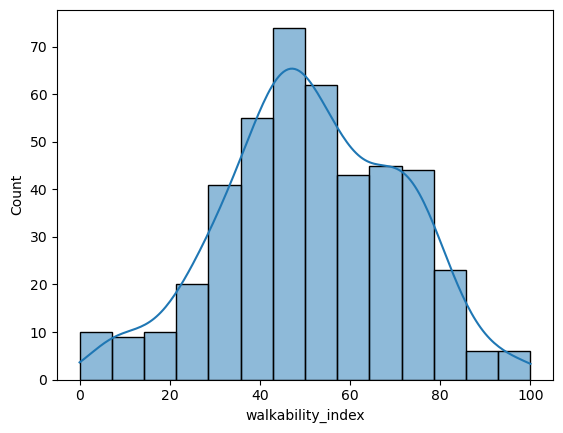

In [116]:
sns.histplot(gdf_rent["walkability_index"], kde=True)

<Axes: >

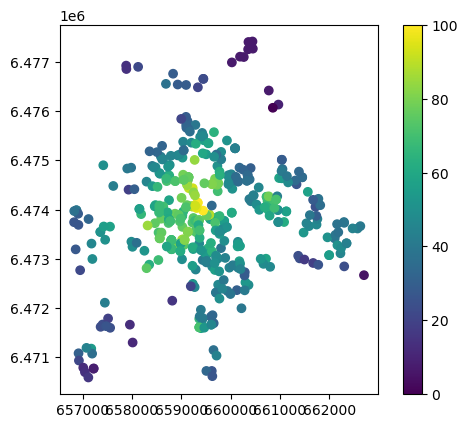

In [117]:
gdf_rent.plot(column="walkability_index", cmap="viridis", legend=True)

### Amenity diversity score

In [118]:
#gdf_rent.columns

In [119]:
radius = 800 # radius of search for services

In [120]:
# counting how many categories of service are within 800 m along the network
category_cols = [col for col in gdf_rent.columns if col.startswith("dist_")]

In [121]:
# boolean
within_radius = gdf_rent[category_cols] <= radius

In [122]:
# counting number of categories within radius
gdf_rent["amenity_diversity_net"] = within_radius.sum(axis=1)

In [123]:
# normalization
gdf_rent["amenity_diversity_net_norm"] = gdf_rent["amenity_diversity_net"] / 21

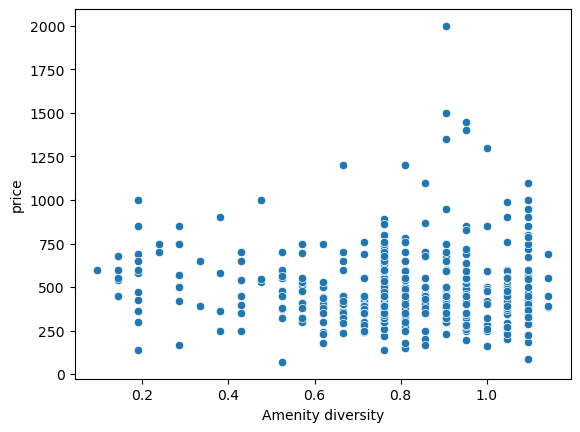

In [124]:
sns.scatterplot(data=gdf_rent, x="amenity_diversity_net_norm", y="price")
plt.xlabel("Amenity diversity")
plt.ylabel("price")
plt.show()

### Plots for data visualization

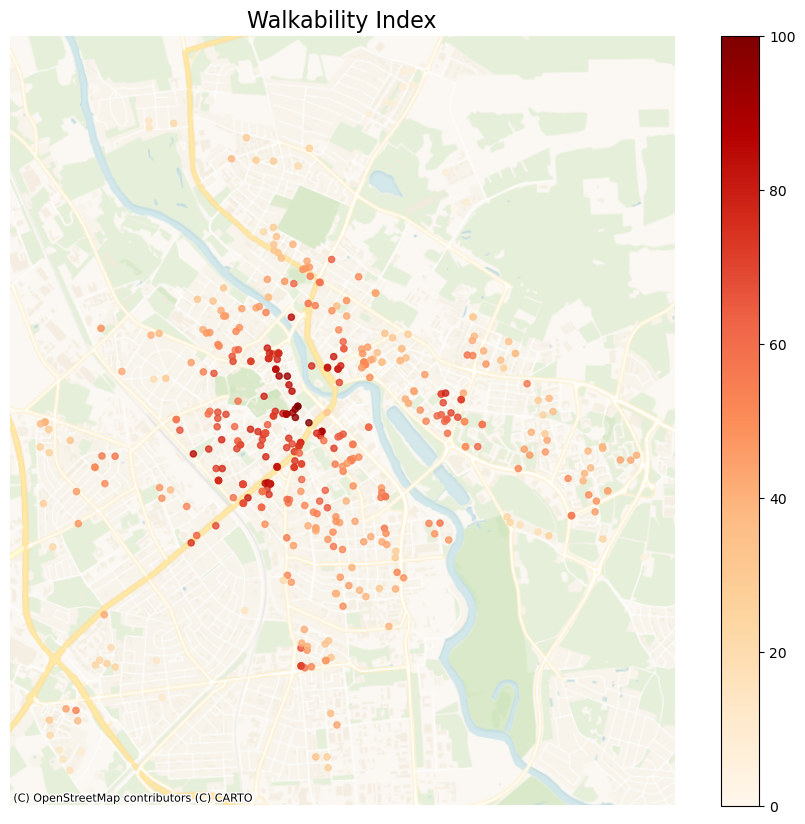

In [125]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_rent.plot(
    column="walkability_index",
    cmap="OrRd",
    legend=True,
    markersize=20,
    alpha=0.8,
    ax=ax
)
#gdf_place_web.boundary.plot(ax=ax, edgecolor="black", linewidth=2)


ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs=gdf_rent.crs)

ax.set_title("Walkability Index", fontsize=16)
ax.axis('off')
plt.show()

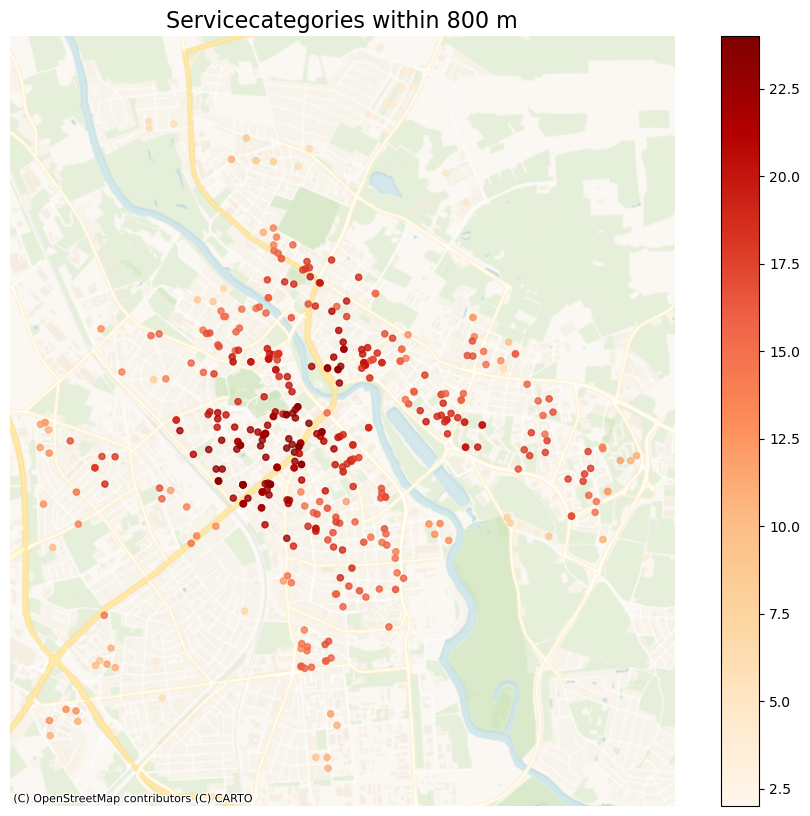

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_rent.plot(
    column="amenity_diversity_net",
    cmap="OrRd",
    legend=True,
    markersize=20,
    alpha=0.8,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs=gdf_rent.crs)

ax.set_title("Servicecategories within 800 m", fontsize=16)
ax.axis('off')
plt.show()


### Saving the engineered features

In [127]:
gdf_rent.to_file("gdf_rent_engineered_trt.gpkg", layer="gdf_rent_engineered_trt", driver="GPKG")

In [ ]:
#gdf_rent_features = gpd.read_file("gdf_rent_engineered.gpkg", layer="gdf_rent_engineered")

In [ ]:
#gdf_rent_features.head()

# Random forest model building

## RF simple without any engineered features

### Reload the data without any engineered features

In [ ]:
df = pd.read_csv("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_csvs/listings_cleaned_tartu.csv", sep=";") 
gdf_rent = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf_rent = gdf_rent.to_crs(epsg=3301)

In [ ]:
print(gdf_rent.columns.tolist())

### Making data ready

In [ ]:
gdf_rent['condition'].unique()

In [ ]:
condition_mapping = {
    'Uus': 5,                        
    'San. remont tehtud': 4,         
    'Renoveeritud': 4,               
    'Valmis': 3.5,                   
    'Heas korras': 3,                
    'Keskmine': 2,                          
    'Vajab san. remonti': 1,
    'Vajab renoveerimist': 0.5,}

In [ ]:
# map condition scores to data
gdf_rent['condition_score'] = gdf_rent['condition'].map(condition_mapping)

In [ ]:
print(gdf_rent.isnull().sum()[gdf_rent.isnull().sum() > 0])

In [ ]:
# fill missing values if any with median
gdf_rent['condition_score'] = gdf_rent['condition_score'].fillna(gdf_rent['condition_score'].median())

In [ ]:
print(gdf_rent.isnull().sum()[gdf_rent.isnull().sum() > 0])

In [ ]:
# removing non-feature columns
exclude_cols = ['geometry', 'latitude', 'longitude', 'price', 'url', 
                'id', 'date_scraped', 'condition']

In [ ]:
# getting all columns that will be used
feature_cols = [col for col in gdf_rent.columns 
                if col not in exclude_cols 
                and gdf_rent[col].dtype in ['int64', 'float64']]

### Train test split

In [ ]:
X = gdf_rent[feature_cols].copy()
y = gdf_rent['price'].copy()

In [ ]:
print(X.isnull().sum()[X.isnull().sum() > 0])

In [ ]:
# fill missing values if any with median
if X.isnull().any().any():
    X = X.fillna(X.median())

In [ ]:
print(X.isnull().sum()[X.isnull().sum() > 0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

### Model training 

In [ ]:
#Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000,max_depth=20,min_samples_split=2,random_state=42,n_jobs=-1)

In [ ]:
rf_model.fit(X_train, y_train)


### Crossvalidation

In [ ]:
cv_scores = cross_val_score(rf_model, X_train, y_train,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)

In [ ]:
# converting negative MSE to RMSE
cv_rmse = np.sqrt(-cv_scores)

In [ ]:
for i, rmse in enumerate(cv_rmse):
    print(f"  Fold {i+1}: {rmse:.2f} EUR")

In [ ]:
print(f"\nAverage CV RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f} EUR")

### Test set test

In [ ]:
# make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# calculating metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# calculating metrics 
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train")
print(f"  RMSE: {train_rmse:.2f} EUR")
print(f"  MAE:  {train_mae:.2f} EUR")
print(f"  R2:   {train_r2:.4f}")

print("Test")
print(f"  RMSE: {test_rmse:.2f} EUR")
print(f"  MAE:  {test_mae:.2f} EUR")
print(f"  R2:   {test_r2:.4f}")

In [ ]:
# As expected the results are bad.

## RF with engineered features

### Data loading

In [ ]:
gdf_rent_features = gpd.read_file("gdf_rent_engineered_trt.gpkg", layer="gdf_rent_engineered_trt")

In [ ]:
print(gdf_rent_features.columns.tolist())

### Making data ready

In [ ]:
condition_mapping = {
    'Uus': 5,                        
    'San. remont tehtud': 4,         
    'Renoveeritud': 4,               
    'Valmis': 3.5,                   
    'Heas korras': 3,                
    'Keskmine': 2,                          
    'Vajab san. remonti': 1,
    'Vajab renoveerimist': 0.5,}

In [ ]:
# map condition scores to data
gdf_rent_features['condition_score'] = gdf_rent_features['condition'].map(condition_mapping)

In [ ]:
# fill missing values if any with median
gdf_rent_features['condition_score'] = gdf_rent_features['condition_score'].fillna(gdf_rent_features['condition_score'].median())

In [ ]:
# # removing non-feature columns
exclude_cols = [
    'id', 'url', 'latitude', 'longitude', 'geometry', 'price', 
    'condition', 'nearest_node']

In [ ]:
score_cols = [c for c in gdf_rent_features.columns if c.startswith("score_")] # removing all columns with score_ in name because they are similar to distance
exclude_cols.extend(score_cols)

In [ ]:
# getting all columns that will be used
feature_cols = [col for col in gdf_rent_features.columns 
                if col not in exclude_cols 
                and gdf_rent_features[col].dtype in ['int64', 'float64', 'Int64', 'Float64']]

### Train test split

In [ ]:
X = gdf_rent_features[feature_cols].copy()
y = gdf_rent_features['price'].copy()

In [ ]:
print(X.isnull().sum()[X.isnull().sum() > 0])

In [ ]:
if X.isnull().any().any():
    X = X.fillna(X.median())

In [ ]:
print(X.isnull().sum()[X.isnull().sum() > 0])

In [ ]:
print(X.columns.tolist())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=200,max_depth=15,min_samples_split=2,random_state=42,n_jobs=-1)

In [ ]:
rf_model.fit(X_train, y_train)

In [ ]:
cv_scores = cross_val_score(rf_model, X_train, y_train,cv=10,scoring='neg_mean_squared_error',n_jobs=-1)

In [ ]:
cv_rmse = np.sqrt(-cv_scores)
print(f"CV RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f} EUR\n")

In [ ]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nTrain: RMSE={train_rmse:.2f} EUR | R²={train_r2:.4f}")
print(f"Test:  RMSE={test_rmse:.2f} EUR | R²={test_r2:.4f} | MAE={test_mae:.2f} EUR")

In [ ]:
# predicts still extremely bad.

In [ ]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance.head(20).to_string(index=False))

In [ ]:
condition_mapping = {
    'Uus': 5,
    'San. remont tehtud': 4,
    'Renoveeritud': 4,
    'Valmis': 3.5,
    'Heas korras': 3,
    'Keskmine': 2,
    'Vajab san. remonti': 1,
    'Vajab renoveerimist': 0.5,}

In [ ]:
gdf['condition_score'] = (gdf['condition'].map(condition_mapping))

In [ ]:
gdf['condition_score'] = gdf['condition_score'].fillna(gdf['condition_score'].median())

In [ ]:
exclude_cols = [
    "id", "url", "condition", "geometry", 'latitude', 'longitude',
    "price", "nearest_node"] # exluding 

In [ ]:
dist_cols = [c for c in gdf.columns if c.startswith("dist_") and c != "dist_center"]  # keep dist_center for kriging
score_cols = [c for c in gdf.columns if c.startswith("score_")] # excluding because krigging will evaluate these

In [ ]:
exclude_cols.extend(dist_cols)
exclude_cols.extend(score_cols)

In [ ]:
feature_cols = [
    c for c in gdf.columns
    if c not in exclude_cols
    and gdf[c].dtype in ["float64", "int64", "Int64", "Float64"]]

In [ ]:
gdf['area_condition'] = gdf['area_sqm'] * gdf['condition_score']
gdf['rooms_floor']    = gdf['rooms'] * gdf['floor']

feature_cols += ['area_condition', 'rooms_floor']

In [ ]:
X = gdf[feature_cols].copy()
y = gdf["price"].copy()
X = X.fillna(X.median())

In [ ]:
print(X.columns.tolist())